In [4]:
# !pip install etna

https://etna-docs.netlify.app/tutorials/get_started.html

In [1]:
import pandas as pd
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3 as db

from etna.datasets.tsdataset import TSDataset
from etna.metrics import SMAPE
from etna.analysis import plot_forecast
from etna.models import ProphetModel

C:\Users\Dima\AppData\Local\Programs\Python\Python39\lib\site-packages\etna\settings.py:45: UserWarning: wandb is not available, to install it, run `pip install etna[wandb]`
  warnings.warn("wandb is not available, to install it, run `pip install etna[wandb]`")
C:\Users\Dima\AppData\Local\Programs\Python\Python39\lib\site-packages\etna\settings.py:61: UserWarning: `tsfresh` is not available, to install it, run `pip install tsfresh==0.19.0 && pip install protobuf==3.20.1`
  warnings.warn(


In [2]:
df_for_etna = pd.read_csv('./df_for_etna.csv')
df_for_etna.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1825 entries, 0 to 1824
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  1825 non-null   object 
 1   target     1825 non-null   float64
 2   segment    1825 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 42.9+ KB


In [191]:
df_for_etna.tail(5)

timestamp  target  segment
1820  2022-11-17    88.0        5
1821  2022-11-18    73.0        5
1822  2022-11-19    77.0        5
1823  2022-11-20    73.0        5
1824  2022-11-21    74.0        5

In [3]:
df = TSDataset.to_dataset(df_for_etna)
df.head()
ts = TSDataset(df, freq="D")
ts.info()

<class 'etna.datasets.TSDataset'>
num_segments: 5
num_exogs: 0
num_regressors: 0
num_known_future: 0
freq: D
         start_timestamp end_timestamp  length  num_missing
segments                                                   
1             2021-11-22    2022-11-21     365            0
2             2021-11-22    2022-11-21     365            0
3             2021-11-22    2022-11-21     365            0
4             2021-11-22    2022-11-21     365            0
5             2021-11-22    2022-11-21     365            0


In [193]:
ts.describe()

start_timestamp end_timestamp  length  num_missing  num_segments  \
segments                                                                    
1             2021-11-22    2022-11-21     365            0             5   
2             2021-11-22    2022-11-21     365            0             5   
3             2021-11-22    2022-11-21     365            0             5   
4             2021-11-22    2022-11-21     365            0             5   
5             2021-11-22    2022-11-21     365            0             5   

          num_exogs  num_regressors  num_known_future freq  
segments                                                    
1                 0               0                 0    D  
2                 0               0                 0    D  
3                 0               0                 0    D  
4                 0               0                 0    D  
5                 0               0                 0    D

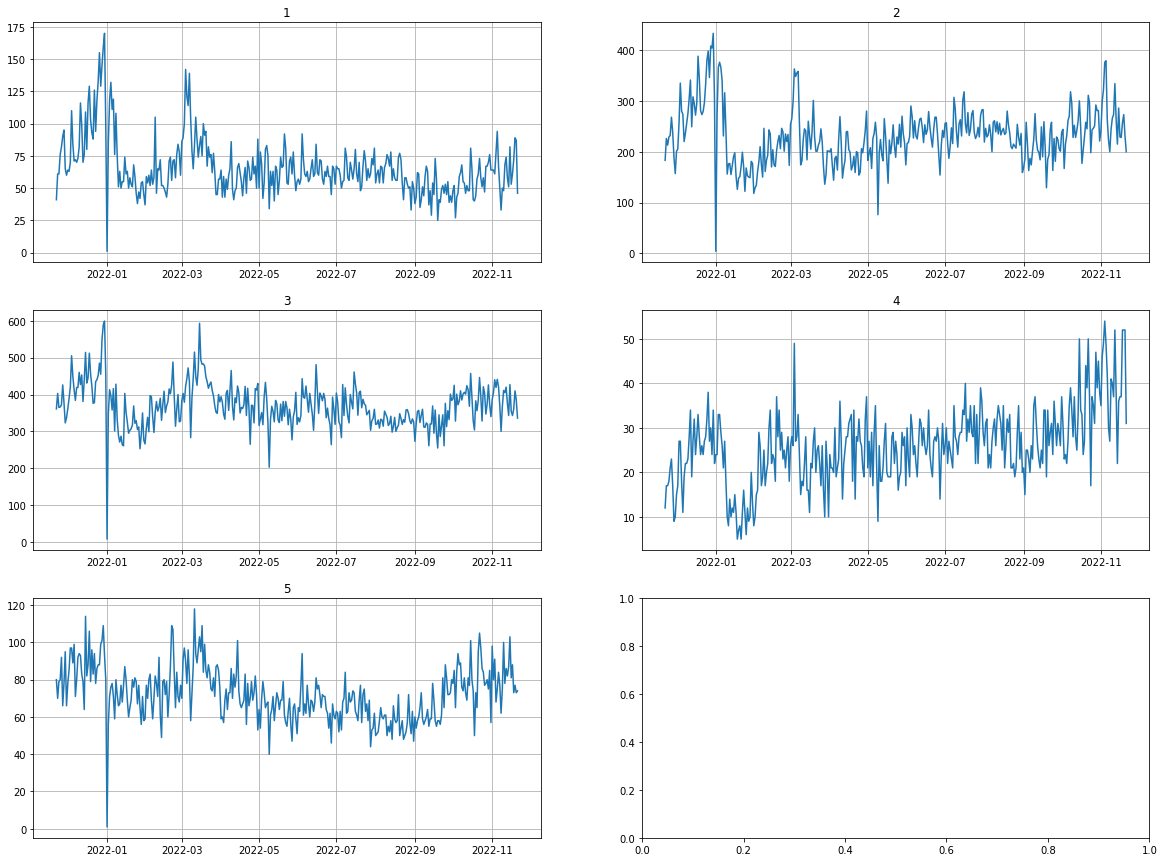

In [194]:
ts.plot()

In [4]:
train_ts, test_ts = ts.train_test_split(
    train_start="2021-11-22",
    train_end="2022-08-31",
    test_start="2022-09-01",
    test_end="2022-11-21",
)

In [12]:
HORIZON = 82
from etna.models import NaiveModel

# Fit the model
model = NaiveModel(lag=12)
model.fit(train_ts)

# Make the forecast
future_ts = train_ts.make_future(future_steps=HORIZON, tail_steps=model.context_size)
forecast_ts = model.forecast(future_ts, prediction_size=HORIZON)

C:\Users\Dima\AppData\Local\Programs\Python\Python39\lib\site-packages\etna\datasets\tsdataset.py:333: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  future_dates = pd.date_range(


In [13]:
smape = SMAPE()
smape(y_true=test_ts, y_pred=forecast_ts)

{'2': 18.566319666886745,
 '3': 12.874934385659435,
 '4': 33.79804123440357,
 '5': 30.72669688369856,
 '1': 27.131363824747435}

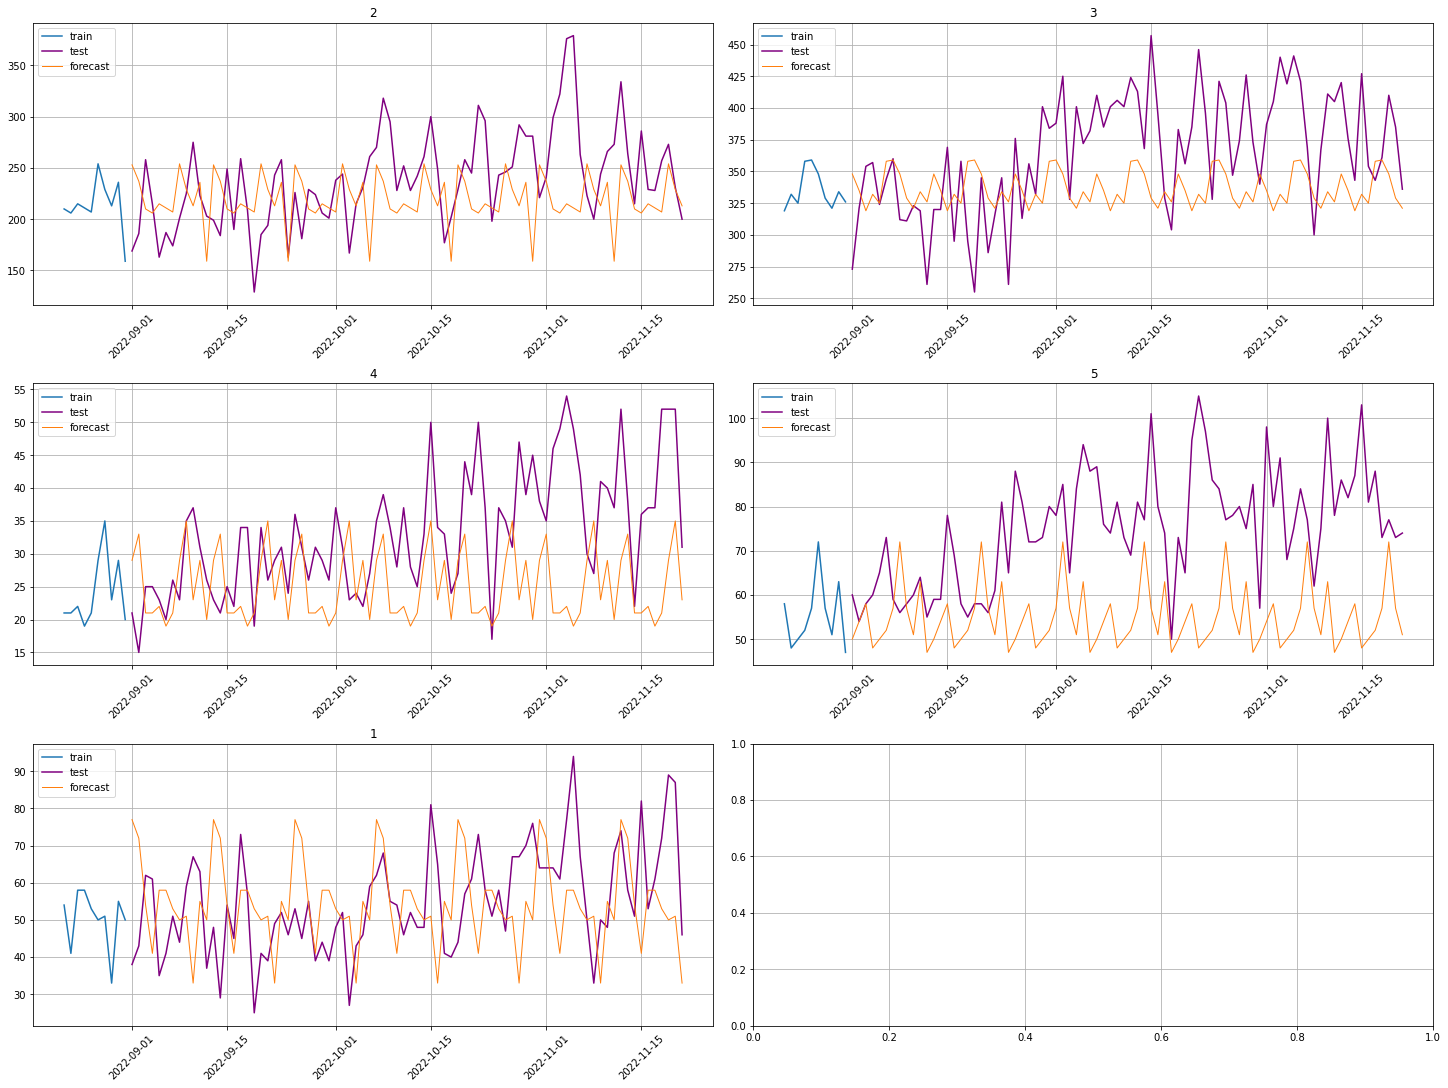

In [14]:
plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=10)

In [15]:
model = ProphetModel()
model.fit(train_ts)

# Make the forecast
future_ts = train_ts.make_future(HORIZON)
forecast_ts = model.forecast(future_ts)

02:10:03 - cmdstanpy - INFO - Chain [1] start processing
02:10:03 - cmdstanpy - INFO - Chain [1] done processing
02:10:03 - cmdstanpy - INFO - Chain [1] start processing
02:10:03 - cmdstanpy - INFO - Chain [1] done processing
02:10:03 - cmdstanpy - INFO - Chain [1] start processing
02:10:03 - cmdstanpy - INFO - Chain [1] done processing
02:10:03 - cmdstanpy - INFO - Chain [1] start processing
02:10:03 - cmdstanpy - INFO - Chain [1] done processing
02:10:03 - cmdstanpy - INFO - Chain [1] start processing
02:10:03 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Dima\AppData\Local\Programs\Python\Python39\lib\site-packages\etna\datasets\tsdataset.py:333: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  future_dates = pd.date_range(


In [16]:
smape(y_true=test_ts, y_pred=forecast_ts)

{'2': 13.219665682250994,
 '3': 13.556979675204422,
 '4': 20.147404277612114,
 '5': 33.63114005538711,
 '1': 19.706732393131805}

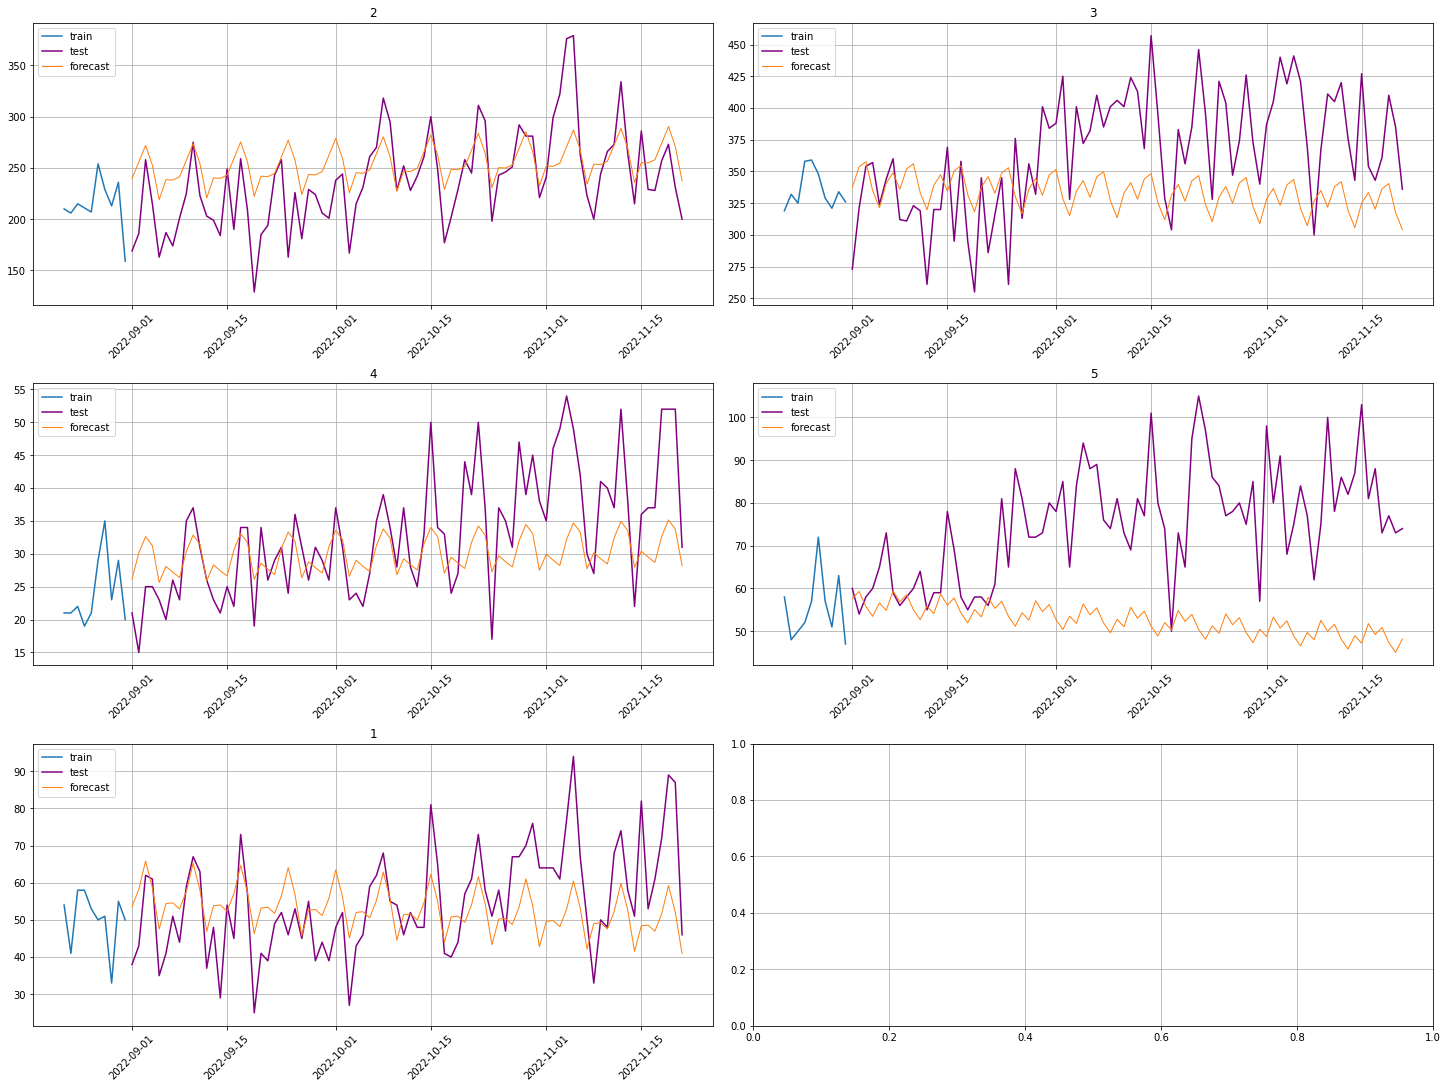

In [17]:
plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=10)

In [119]:
from etna.transforms import LagTransform, LogTransform

lags = LagTransform(in_column="target", lags=list(range(8, 24, 1)))
log = LogTransform(in_column="target")
transforms = [log, lags]
train_ts.fit_transform(transforms)

In [120]:
from etna.models import CatBoostMultiSegmentModel

model = CatBoostMultiSegmentModel()
model.fit(train_ts)
future_ts = train_ts.make_future(future_steps=HORIZON)
forecast_ts.fit_transform(transforms)
forecast_ts = model.forecast(future_ts)
forecast_ts.inverse_transform()

C:\Users\Dima\AppData\Local\Programs\Python\Python39\lib\site-packages\etna\datasets\tsdataset.py:333: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  future_dates = pd.date_range(
C:\Users\Dima\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\blocks.py:402: RuntimeWarning: overflow encountered in expm1
  result = func(self.values, **kwargs)


In [121]:
from etna.metrics import SMAPE

smape = SMAPE()
smape(y_true=test_ts, y_pred=forecast_ts)

C:\Users\Dima\AppData\Local\Programs\Python\Python39\lib\site-packages\etna\metrics\functional_metrics.py:84: RuntimeWarning: invalid value encountered in true_divide
  2 * np.abs(y_pred_array - y_true_array) / (np.abs(y_true_array) + np.abs(y_pred_array)).clip(eps)


{'2': 199.9999999991529,
 '3': nan,
 '4': 199.99999998704897,
 '5': 199.99999999941076,
 '1': 199.9999999995047}

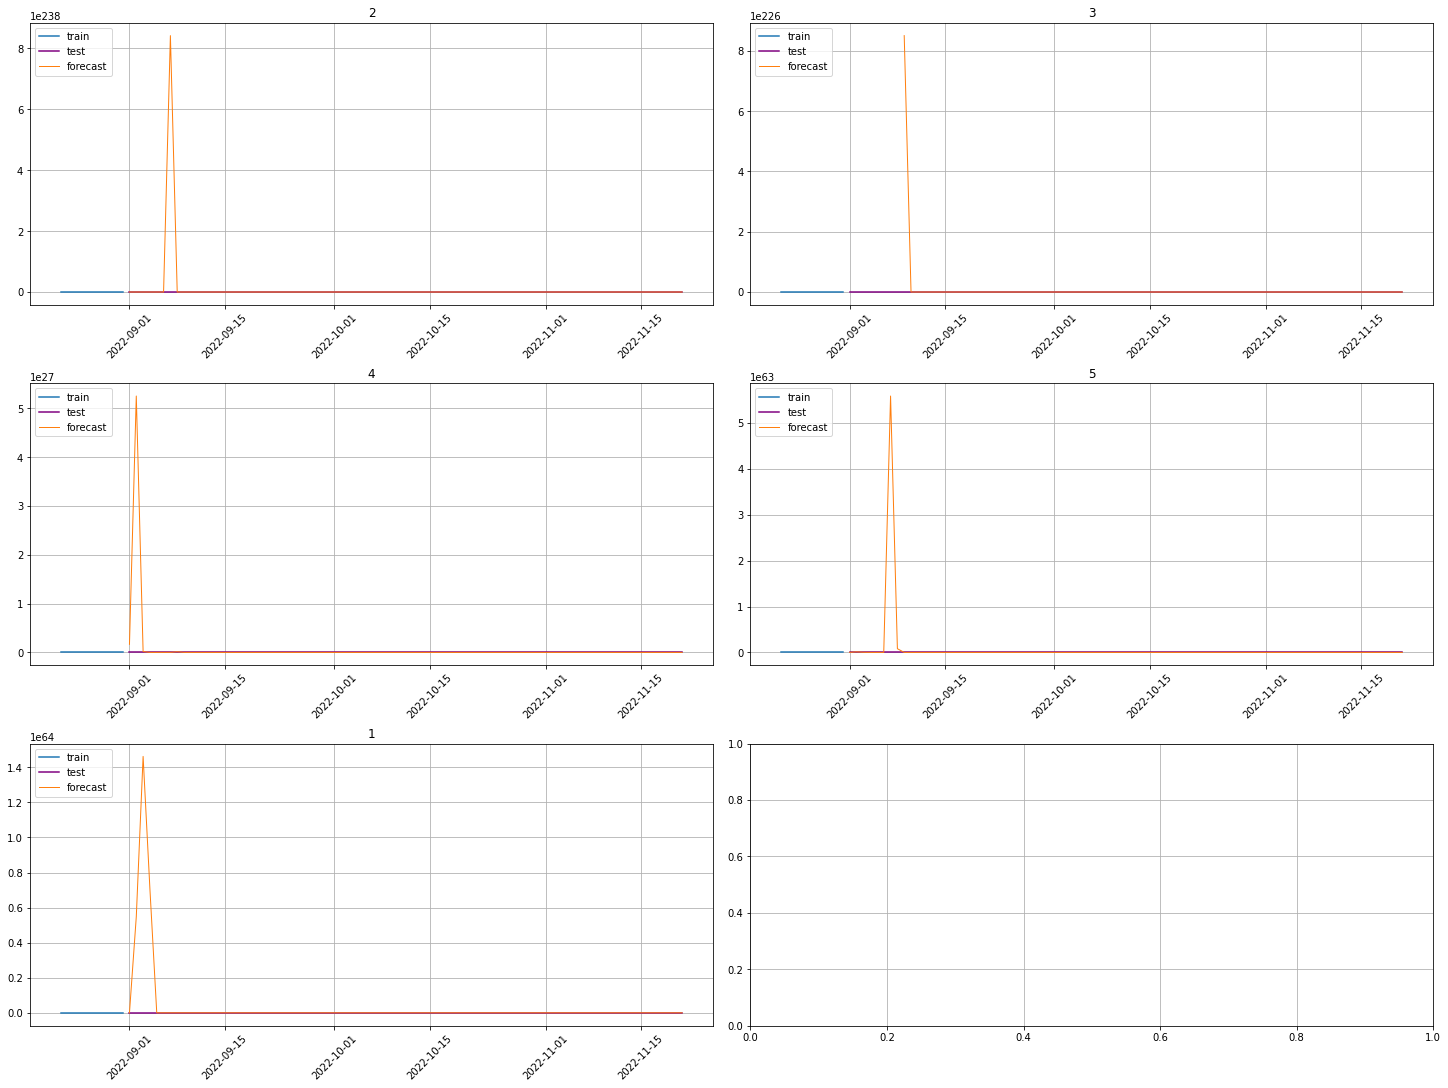

In [122]:
from etna.analysis import plot_forecast

train_ts.inverse_transform()
plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=10)

Pipeline

In [ ]:
# model = Pipeline(
#     model=CatBoostMultiSegmentModel(),
#     transforms=transforms,
#     horizon=HORIZON,
# )
# model.fit(train_ts)
# forecast_ts = model.forecast()

ARIMA from sktime

from:
https://habr.com/ru/company/sbermegamarket/blog/692392/

In [36]:
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.base import ForecastingHorizon
from sktime.utils.plotting import plot_series
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

In [32]:
y = df_for_etna[df_for_etna.segment == 1]['target']
y_train, y_test = temporal_train_test_split(y, test_size=int(365*0.2))

fh = ForecastingHorizon(y_test.index, is_relative=False)

0.2309641497237825

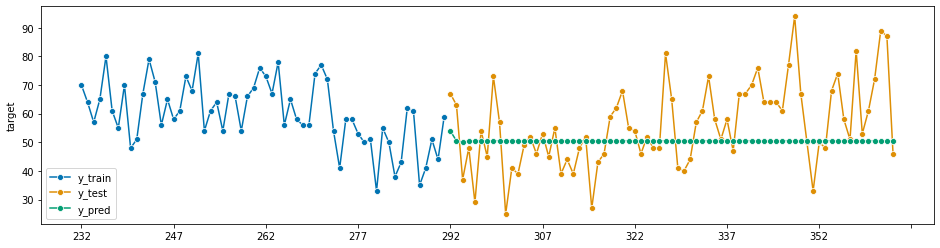

In [39]:
forecaster = AutoARIMA(sp=52, suppress_warnings=True)

forecaster.fit(y_train)
y_pred = forecaster.predict(fh)

plot_series(y_train.tail(60), y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_pred, y_test)

In [46]:
from statsmodels.tsa.arima.model import ARIMA
import statsmodels as sm

In [53]:
model = ARIMA(y_train, order=(12,1,0))
model_fit = model.fit()
output = model_fit.forecast()

In [57]:
output

292    59.937764
dtype: float64

In [64]:
y_train_ = y_train.copy()
predictions = []

In [ ]:
for t in range(len(y_train_)):
    model = ARIMA(y_train_, order=(12,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    predictions.append(output)
    obs = y_train_.iloc[t]
    y_train_ = pd.concat([y_train_, pd.Series(obs)])

In [97]:
y_true = y_test.values
y_pred = np.array(predictions)[:, 0][:73]

In [98]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
mean_squared_error(y_true, y_pred)

1661.7665557797754

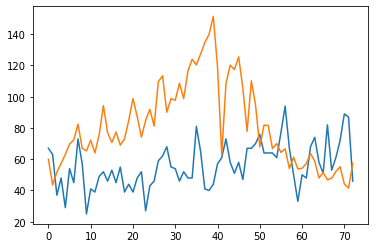

In [99]:
plt.plot(y_true)
plt.plot(y_pred)
plt.show()

EDA Tutorial

In [123]:
train_ts, test_ts = ts.train_test_split(
    train_start="2021-11-22",
    train_end="2022-08-31",
    test_start="2022-09-01",
    test_end="2022-11-21",
)

In [127]:
from etna.analysis import (
    cross_corr_plot,
    distribution_plot,
    acf_plot,
    plot_correlation_matrix,
)

Autocorrelation & partial autocorrelation

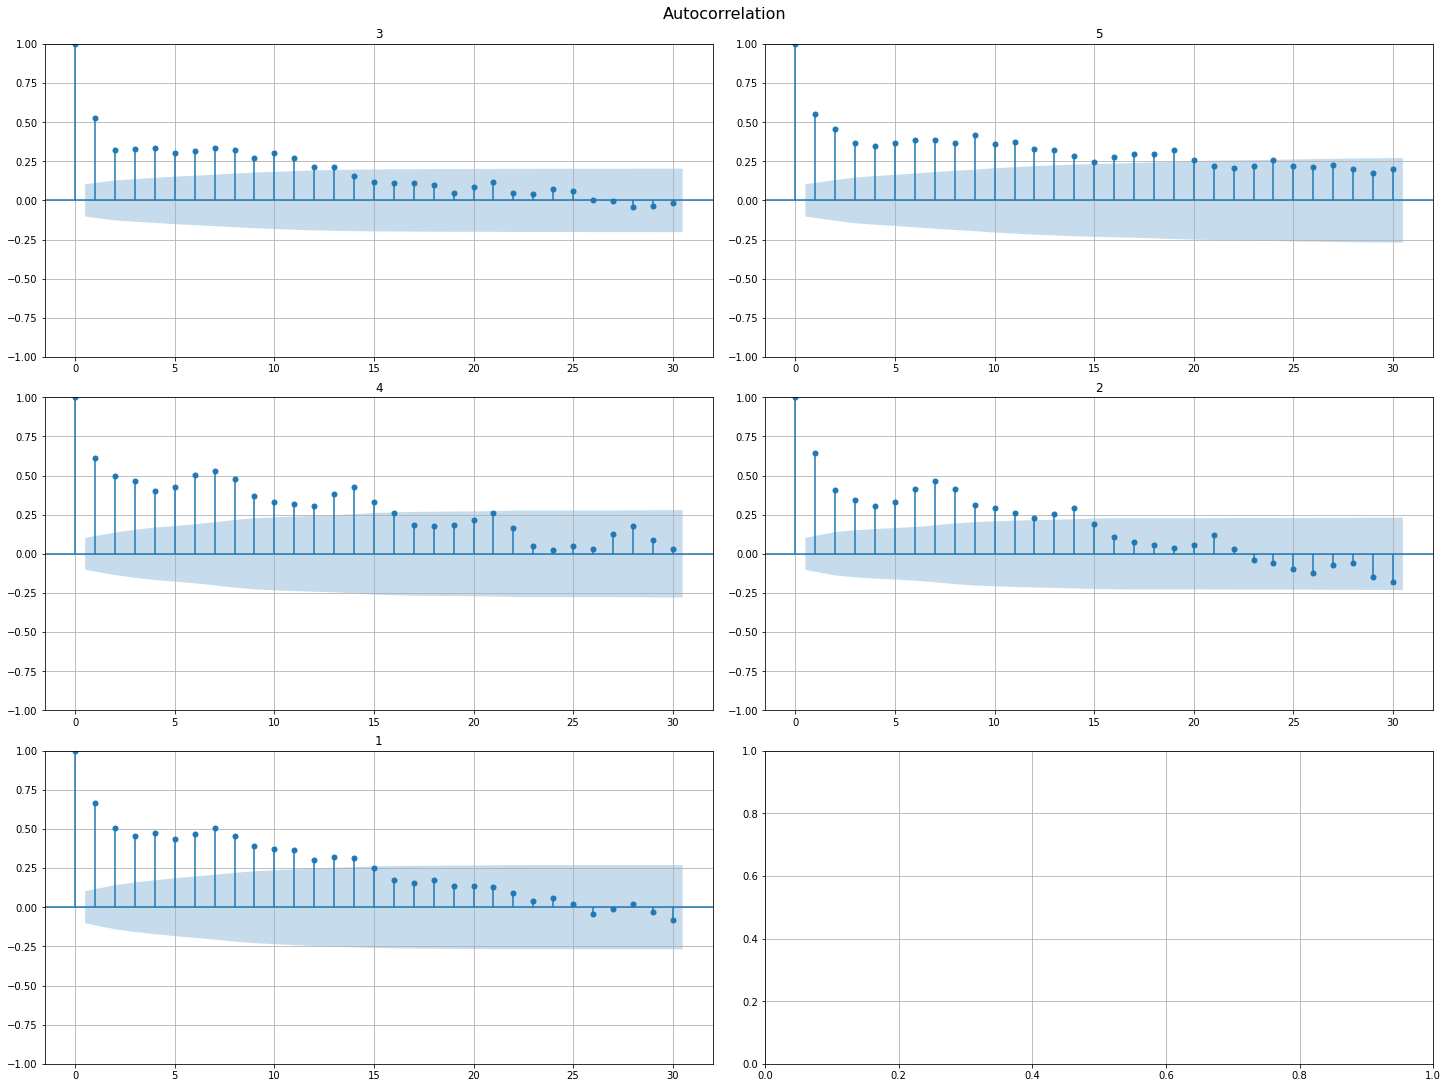

In [133]:
acf_plot(ts, lags=30)

C:\Users\Dima\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
C:\Users\Dima\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
C:\Users\Dima\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting

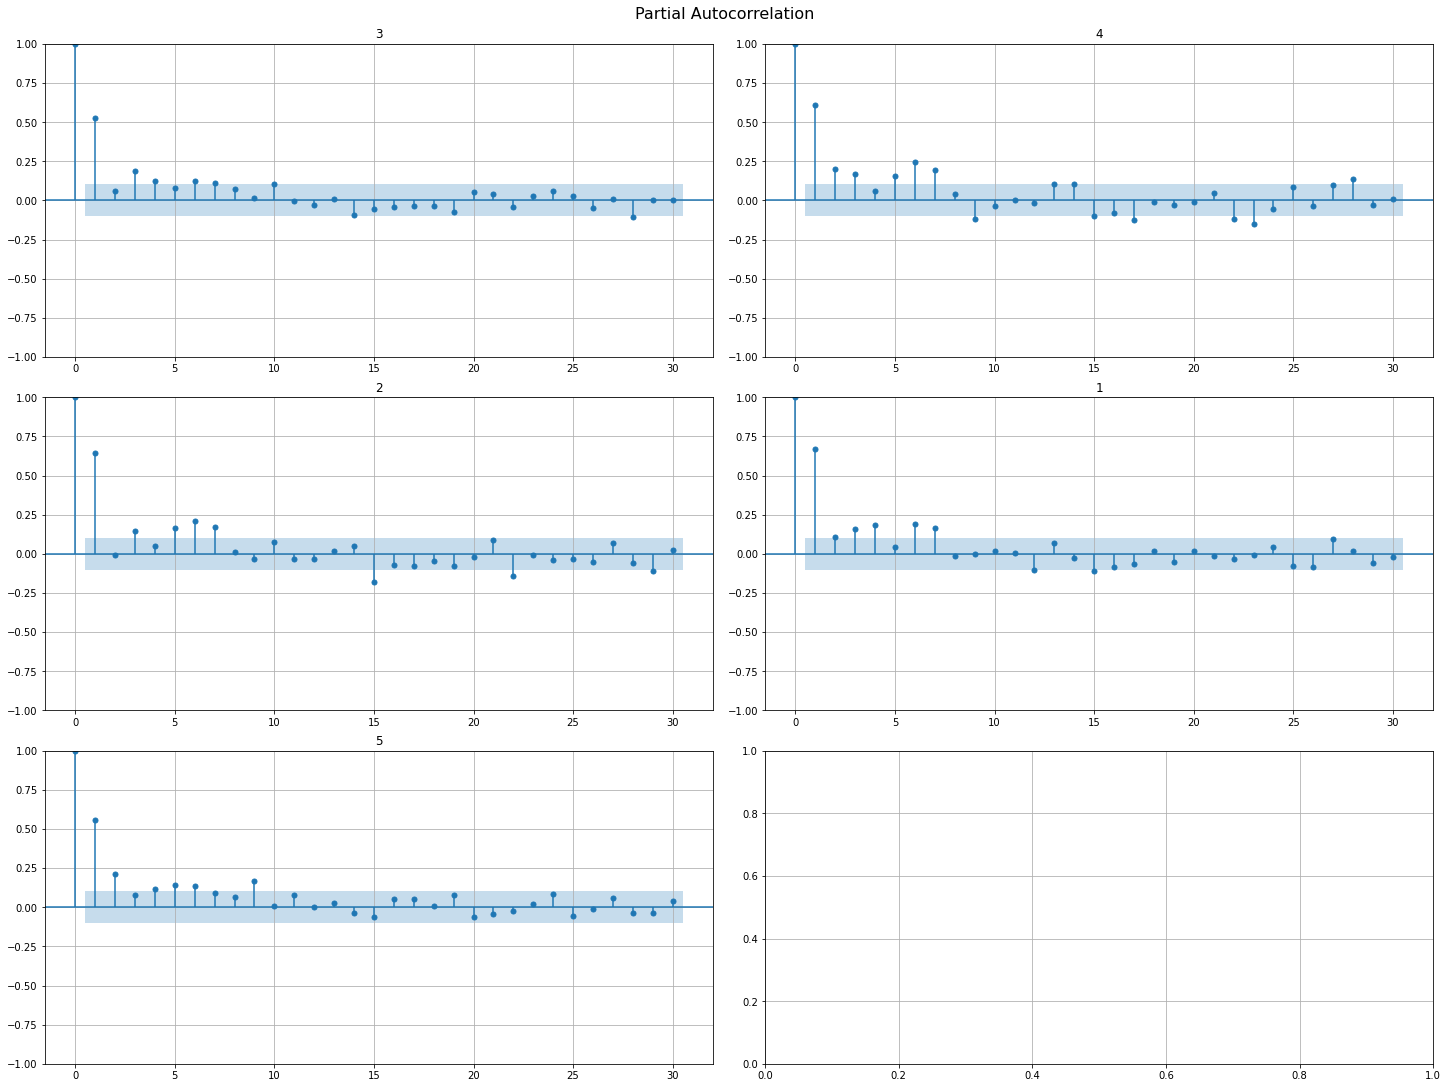

In [196]:
acf_plot(ts, lags=30, partial=True)

cross corr

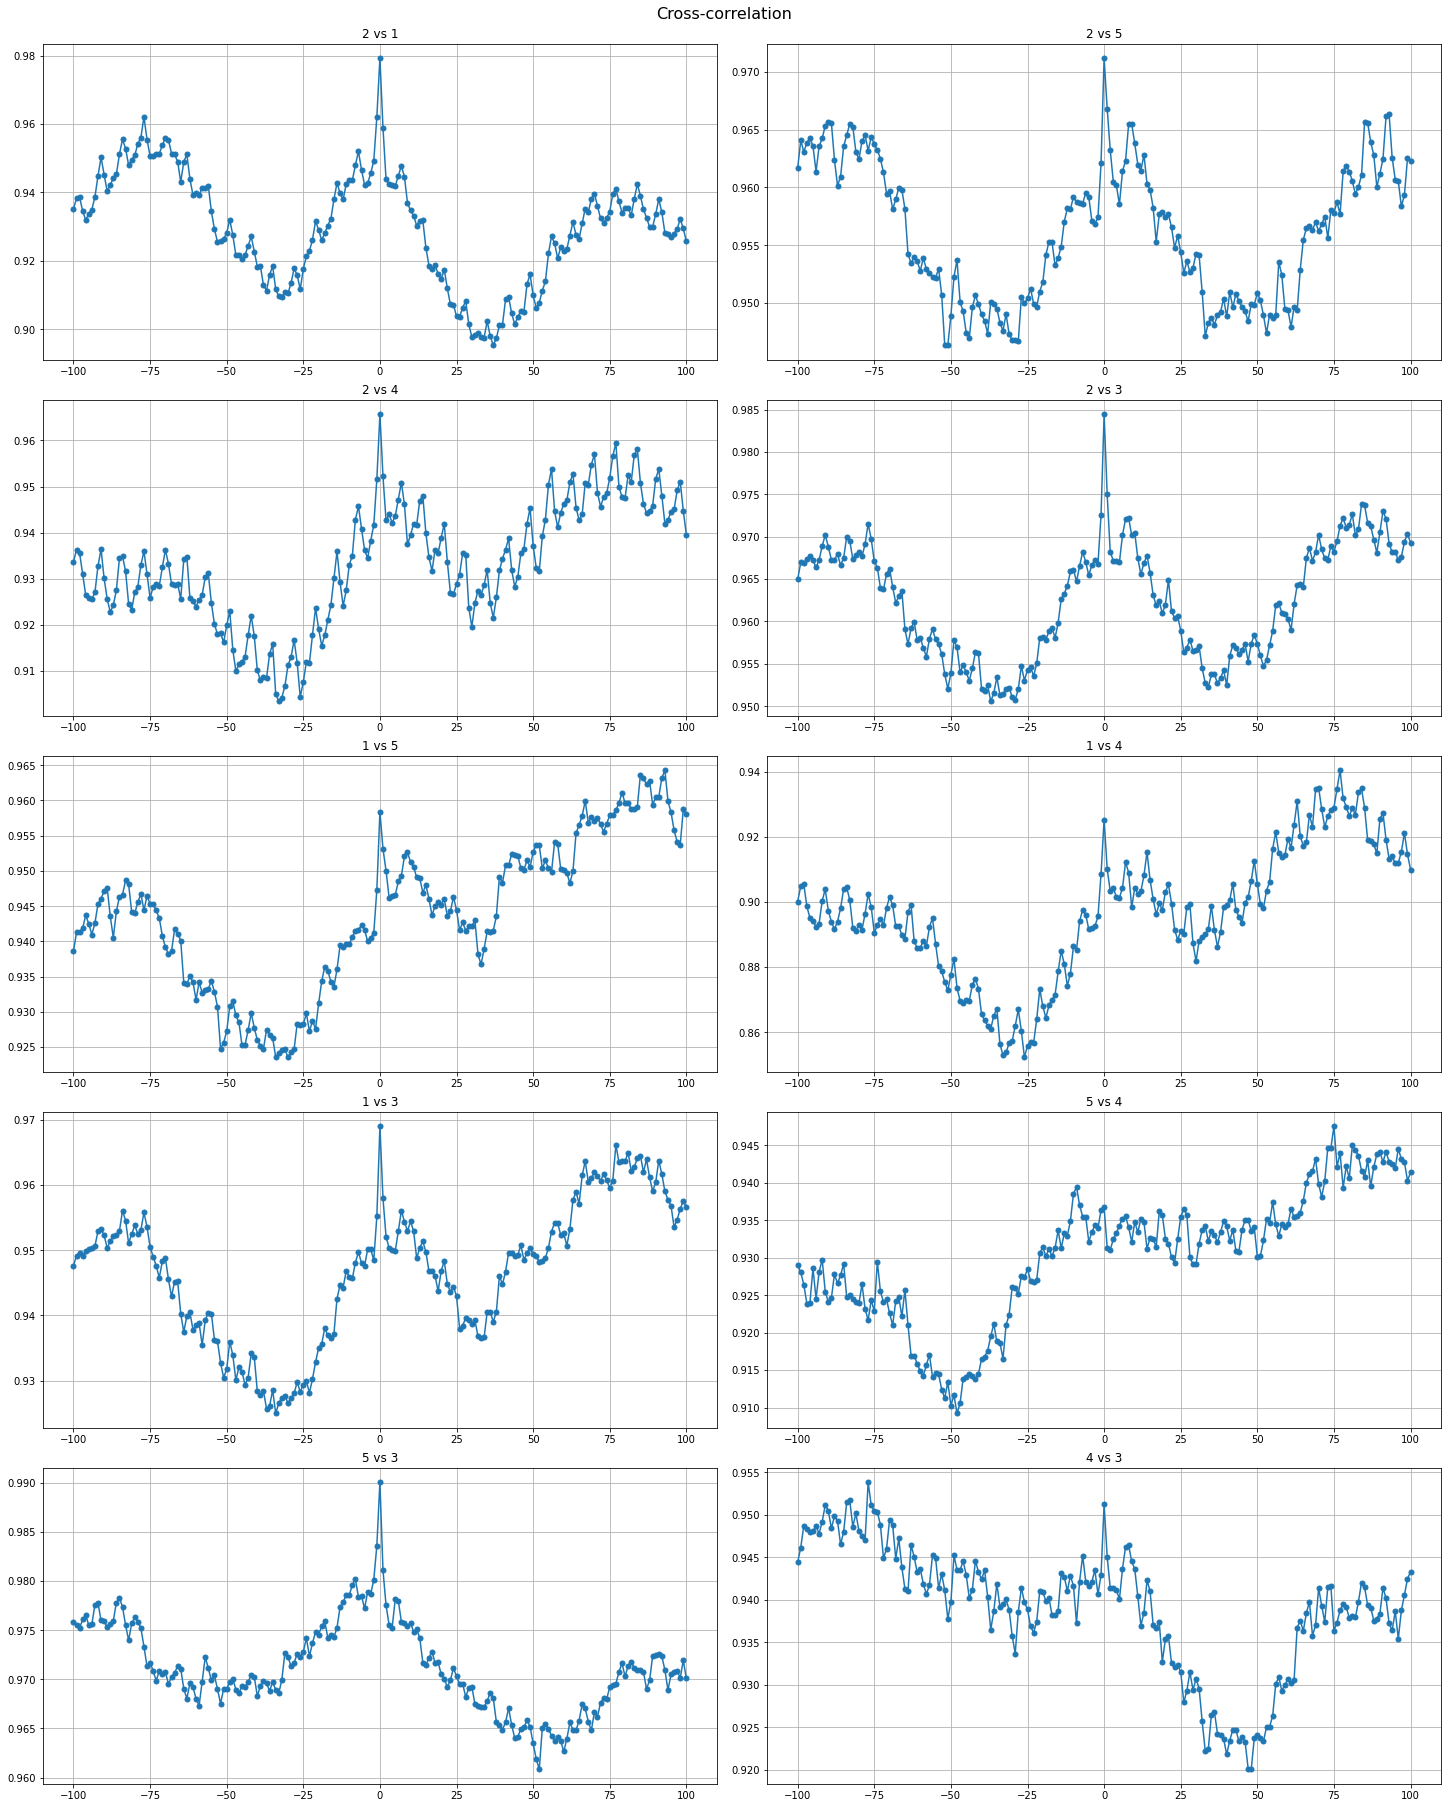

In [197]:
cross_corr_plot(ts, maxlags=100)

Correlation heatmap

In [199]:
from etna.transforms import LagTransform

In [200]:
lags = LagTransform(in_column="target", lags=[1, 7], out_column="lag")
ts.fit_transform([lags])

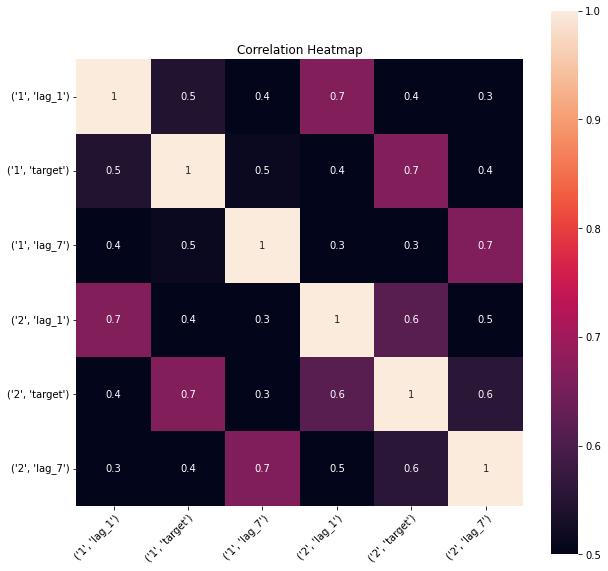

In [202]:
plot_correlation_matrix(ts, segments=["1", "2"], method="spearman", vmin=0.5, vmax=1)

Distribution

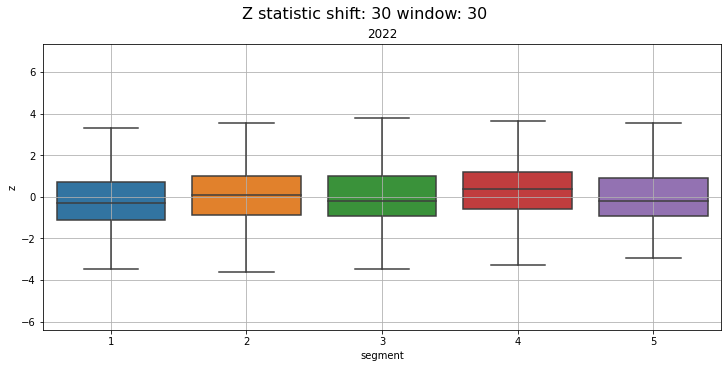

In [204]:
distribution_plot(ts, freq="1Y")

Trend

In [233]:
from etna.analysis import plot_trend
from etna.transforms import LinearTrendTransform

In [234]:
trends = [
    LinearTrendTransform(in_column="target", poly_degree=1),
    LinearTrendTransform(in_column="target", poly_degree=2),
]

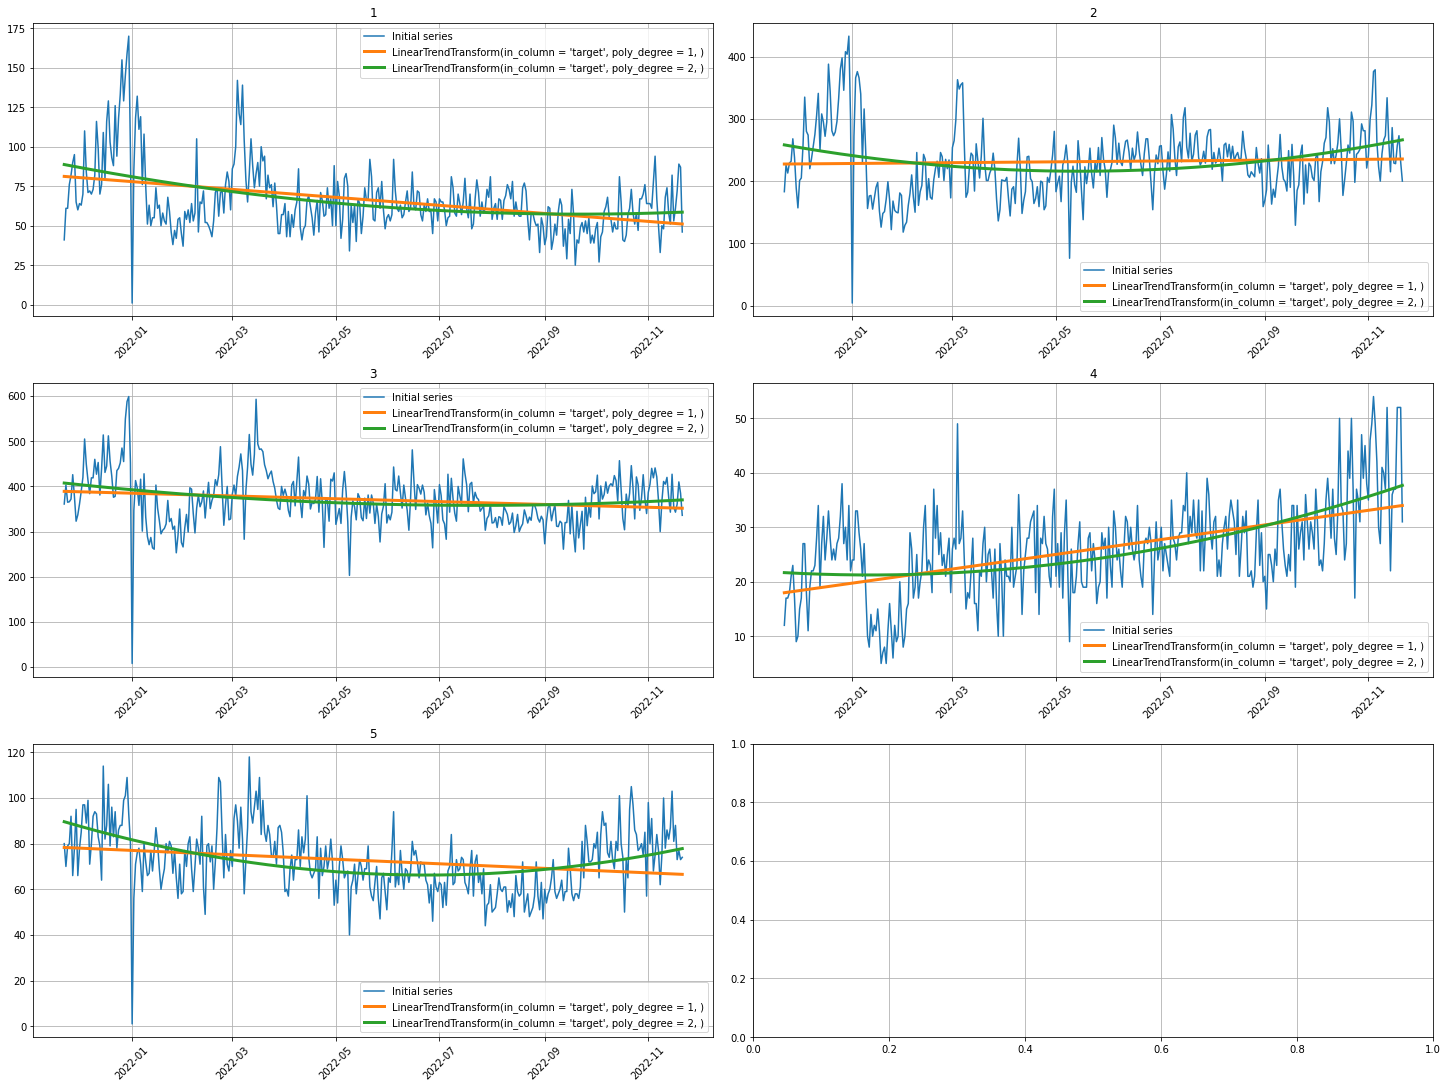

In [235]:
plot_trend(ts, trend_transform=trends)

Seasonality

In [236]:
from etna.analysis import plot_periodogram, stl_plot, seasonal_plot

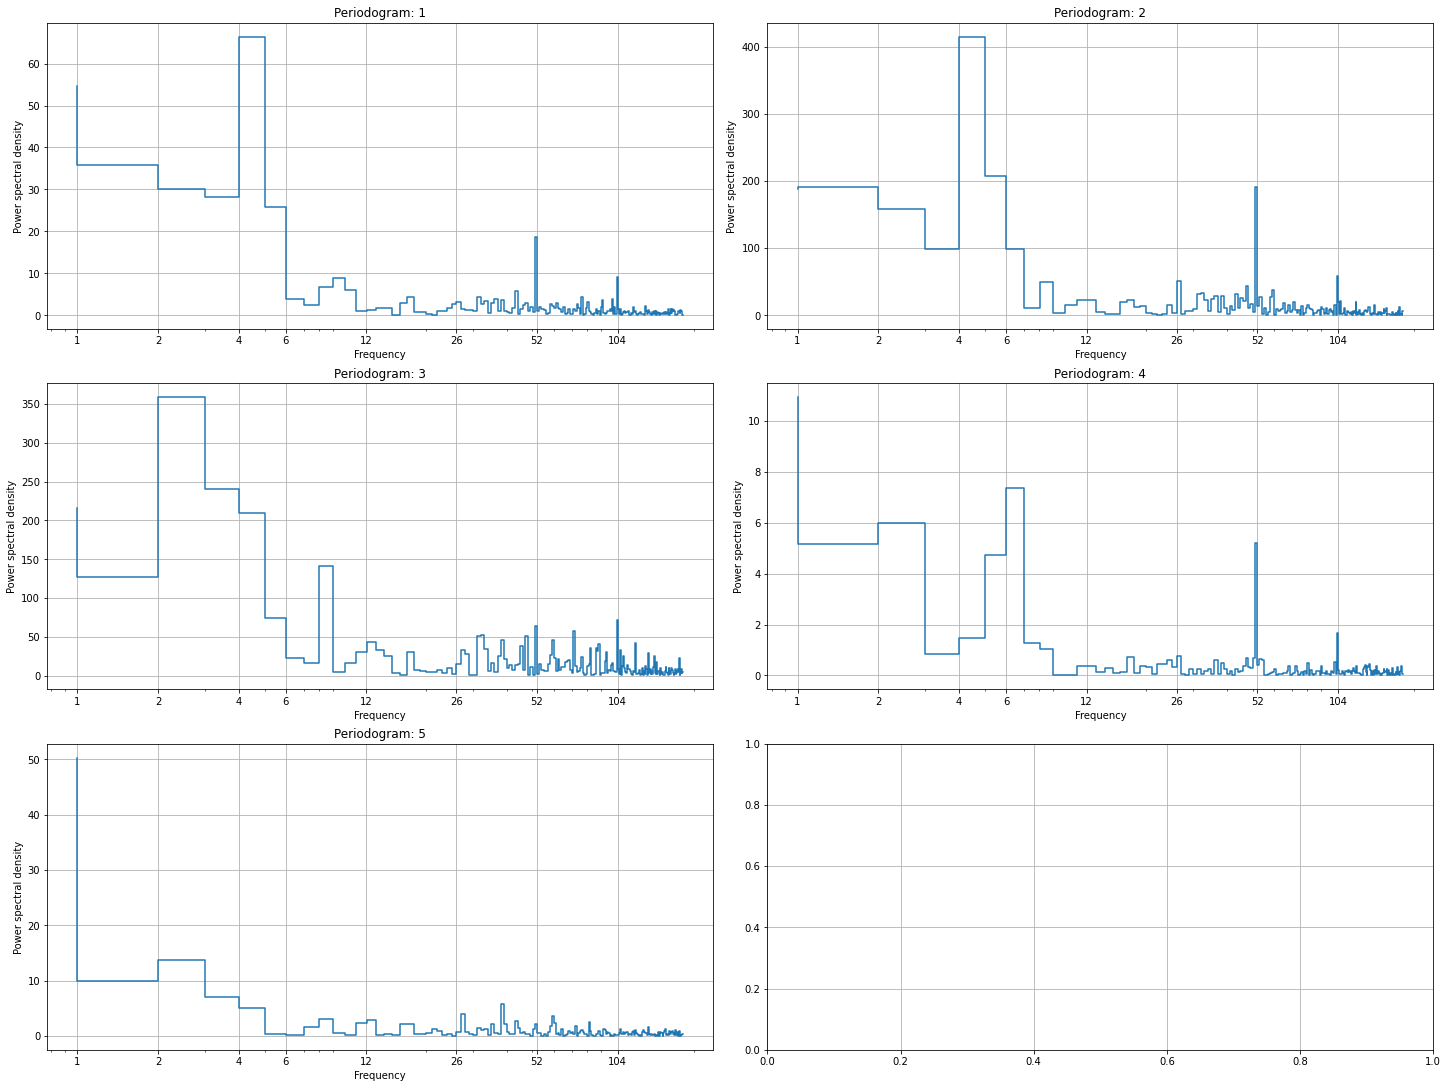

In [237]:
plot_periodogram(ts, period=365.2425, amplitude_aggregation_mode="per-segment", xticks=[1, 2, 4, 6, 12, 26, 52, 104])

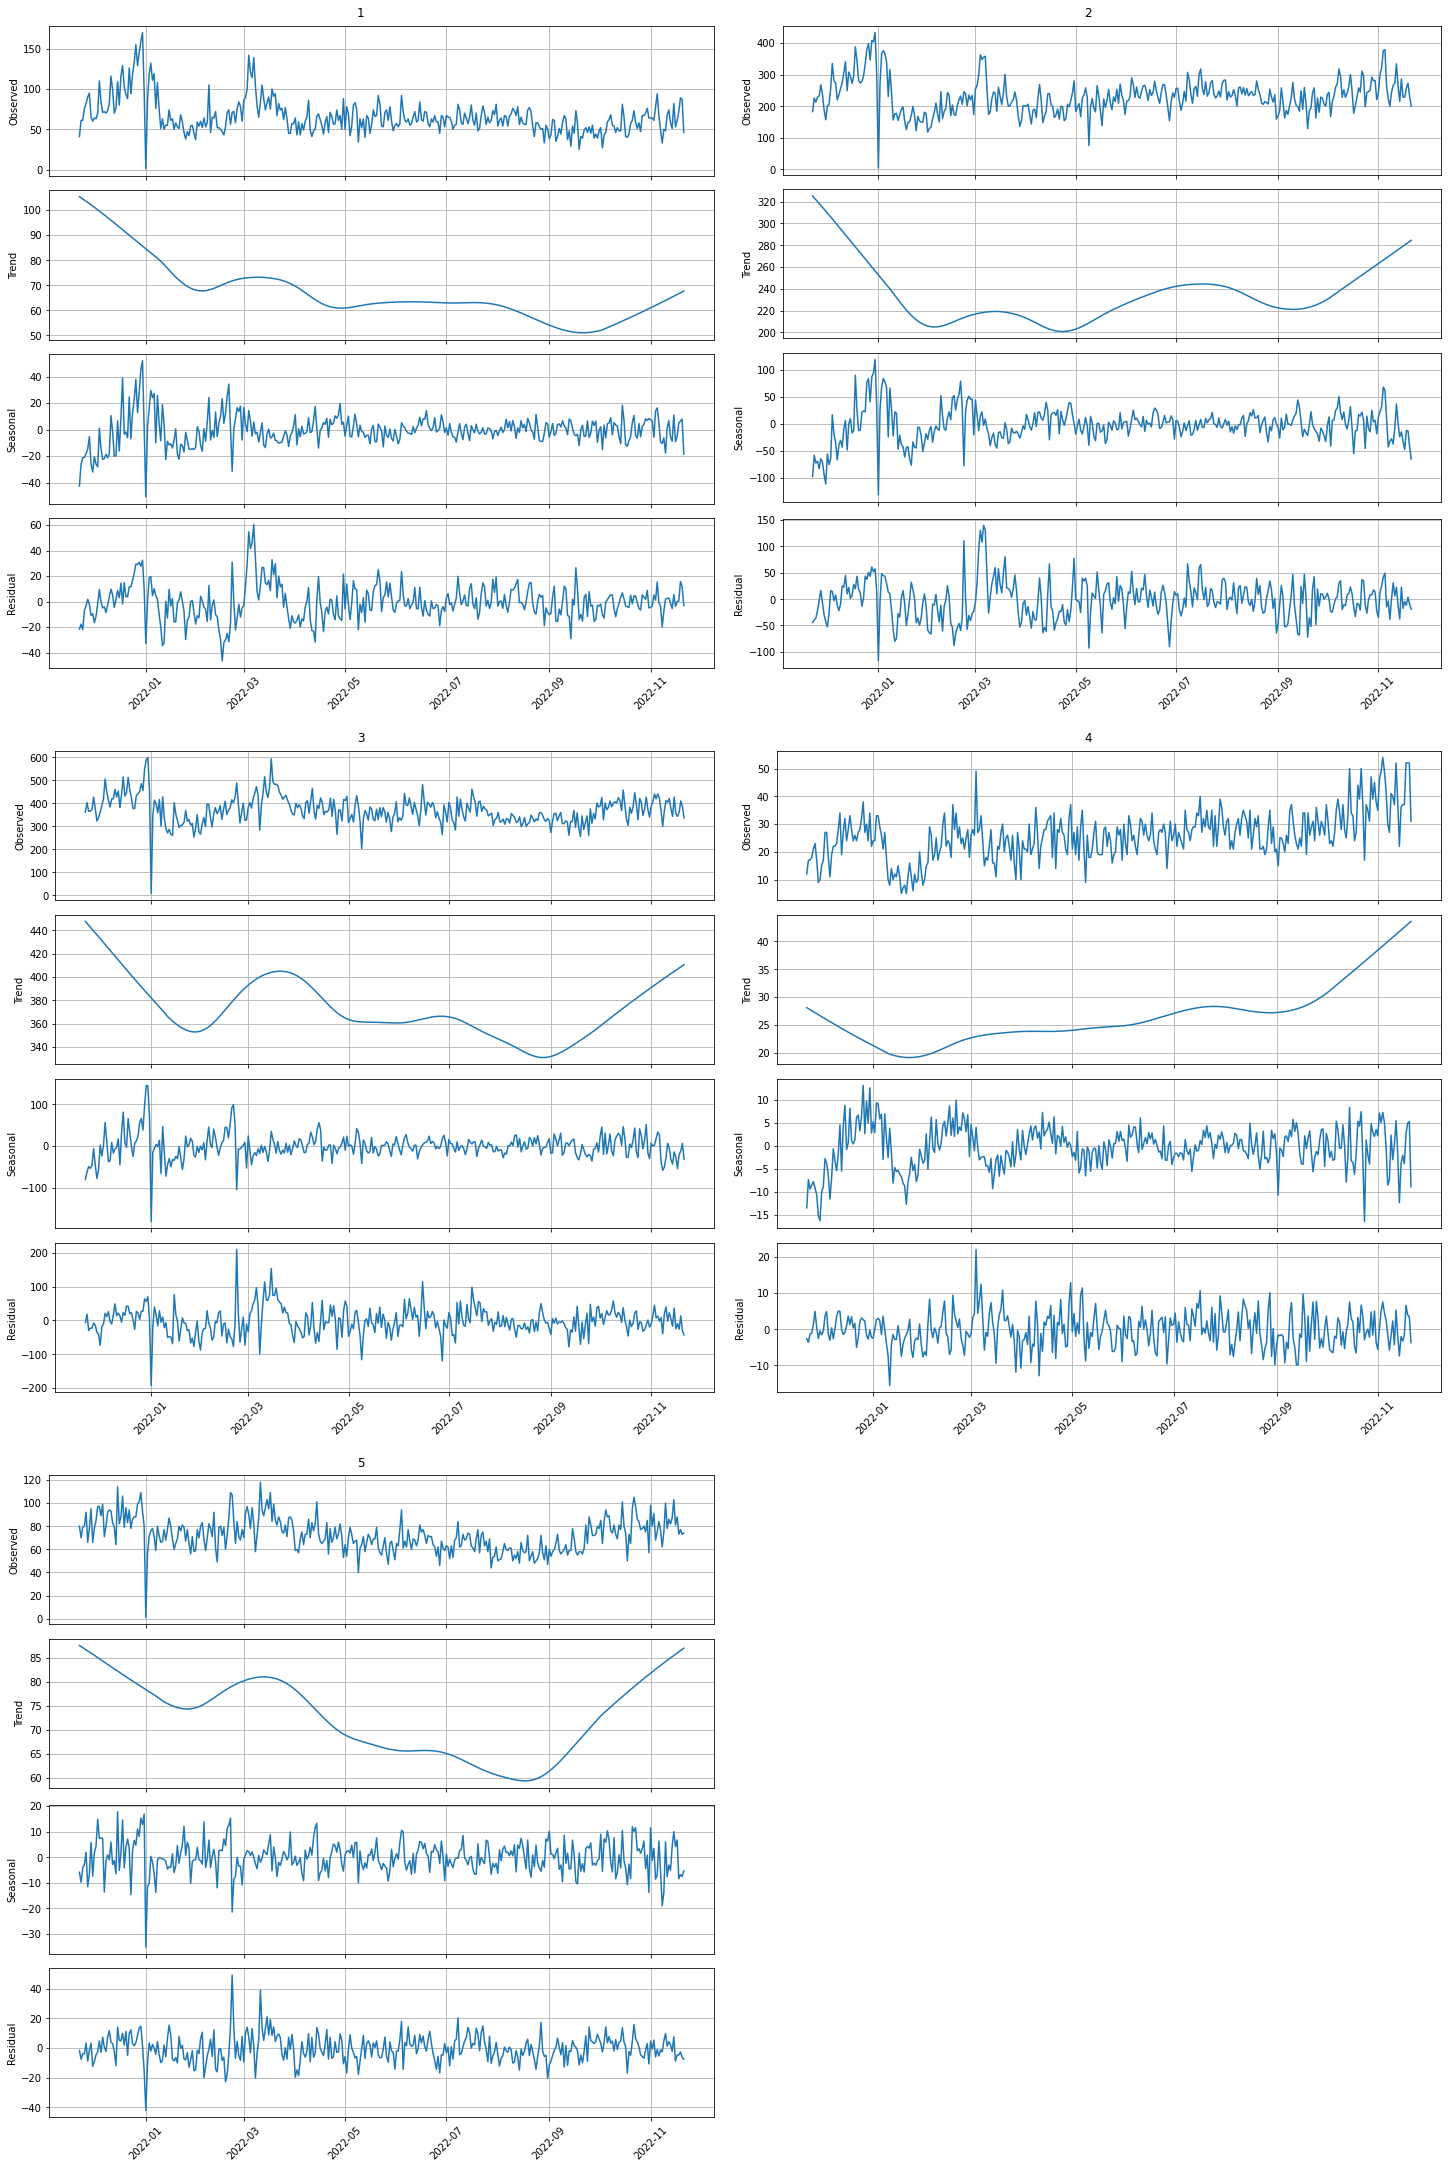

In [238]:
stl_plot(ts=ts, period=52)

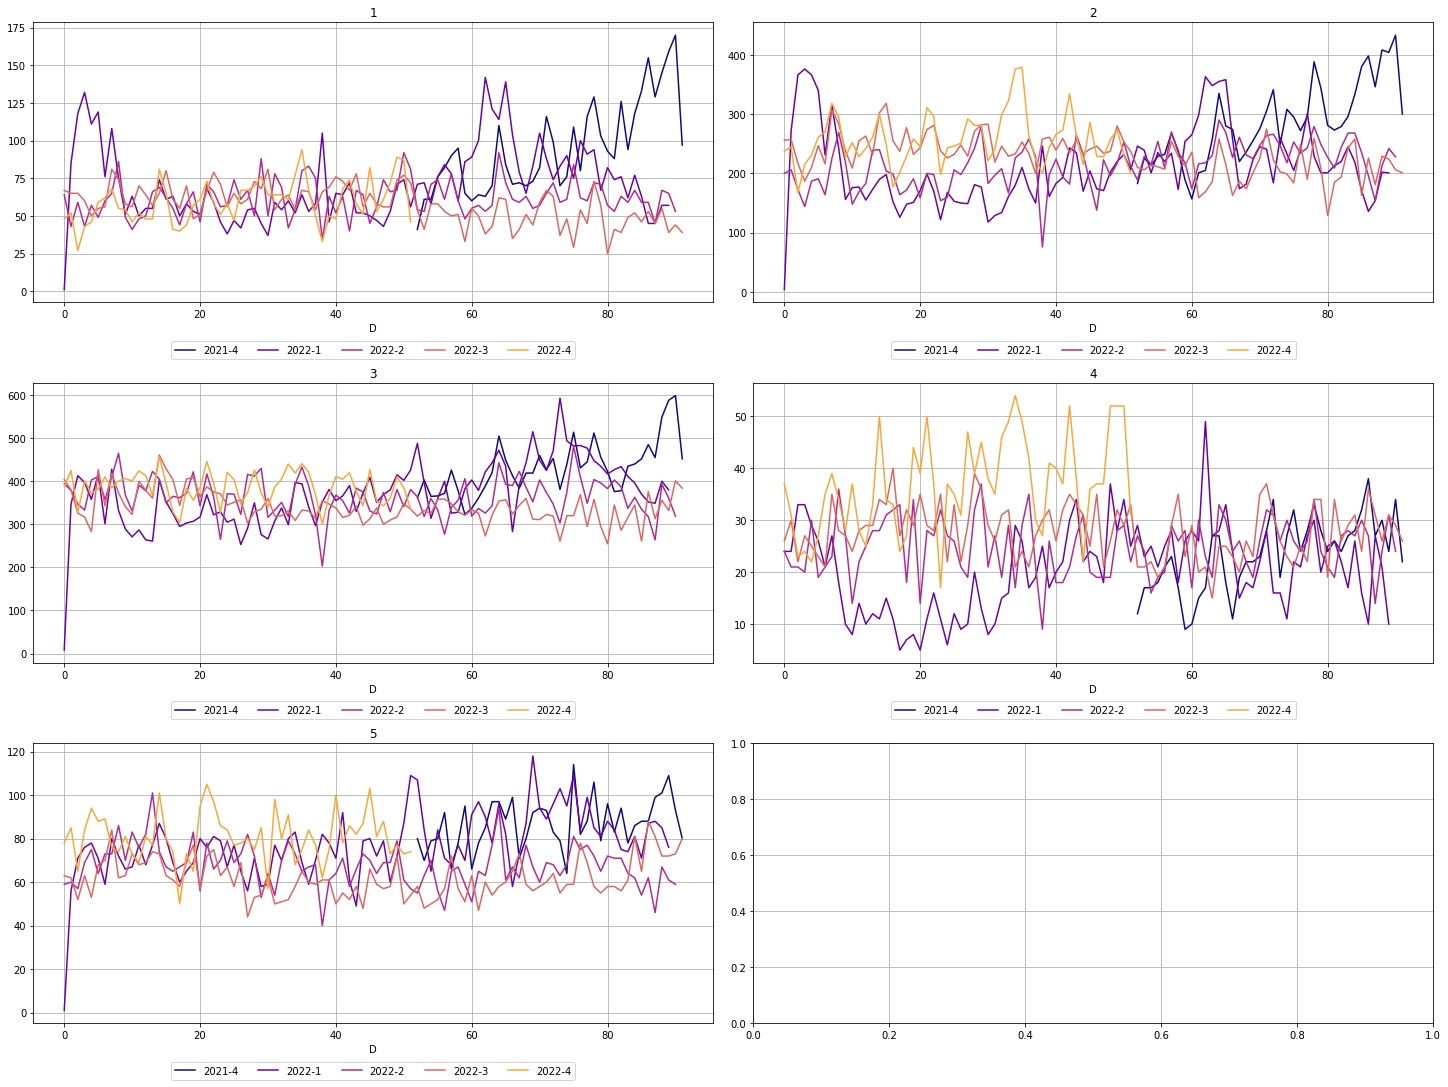

In [239]:
seasonal_plot(ts=ts, cycle="quarter")

Outliers

In [240]:
from etna.analysis.outliers import get_anomalies_median, get_anomalies_density
from etna.analysis import plot_anomalies

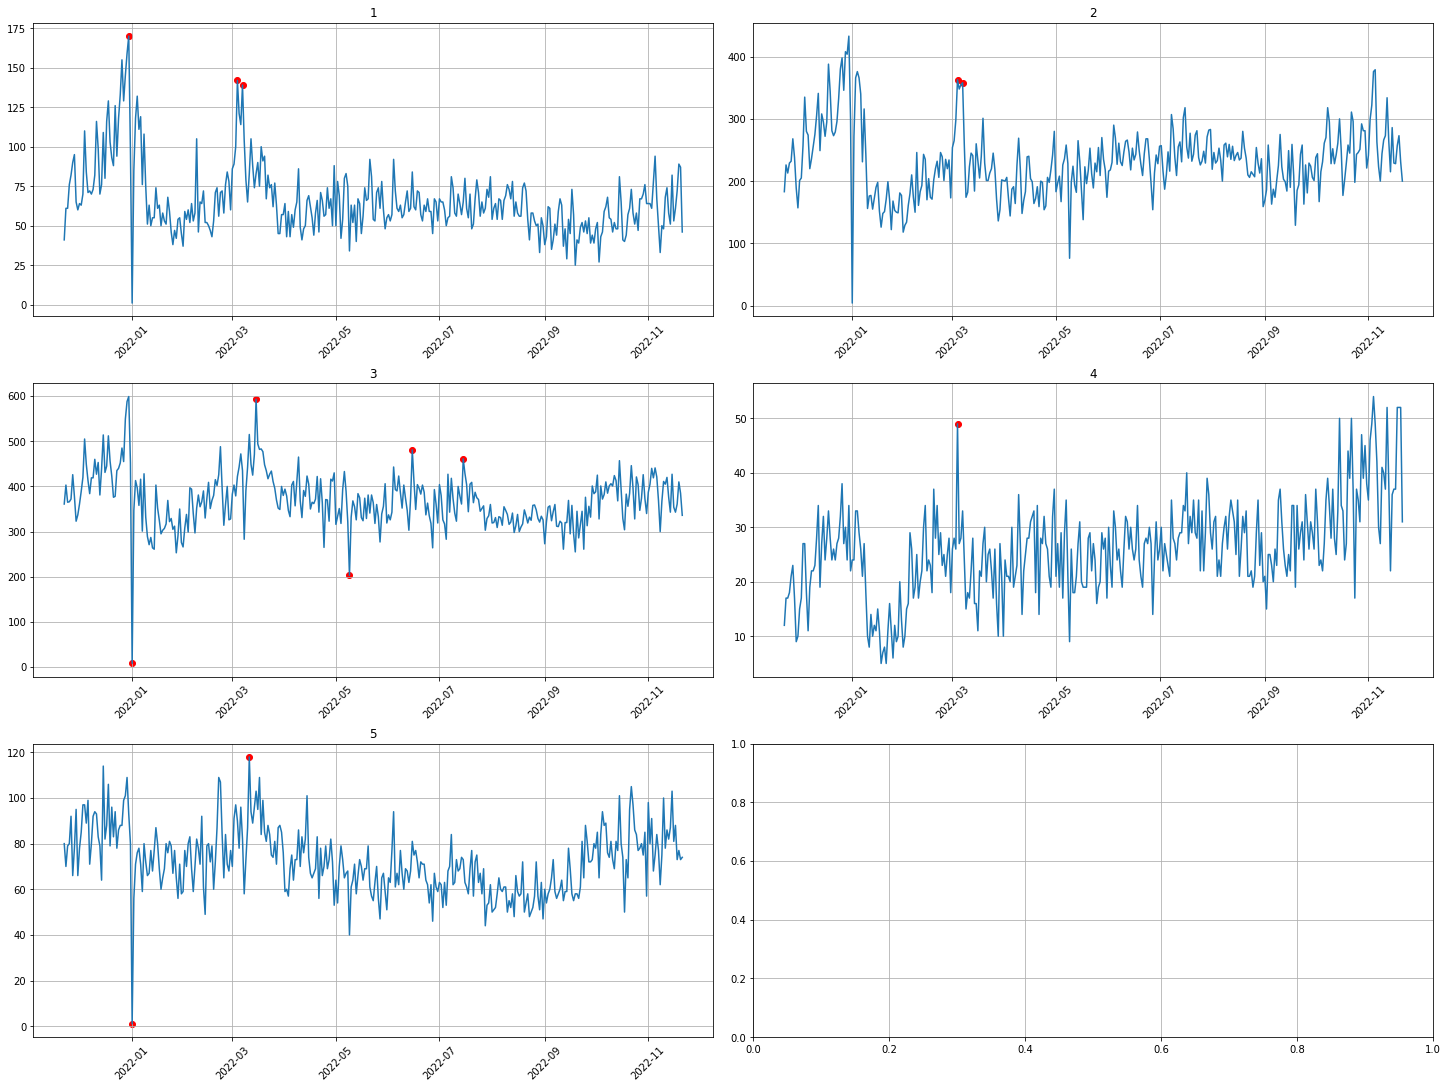

In [241]:
anomaly_dict = get_anomalies_median(ts, window_size=100)
plot_anomalies(ts, anomaly_dict)

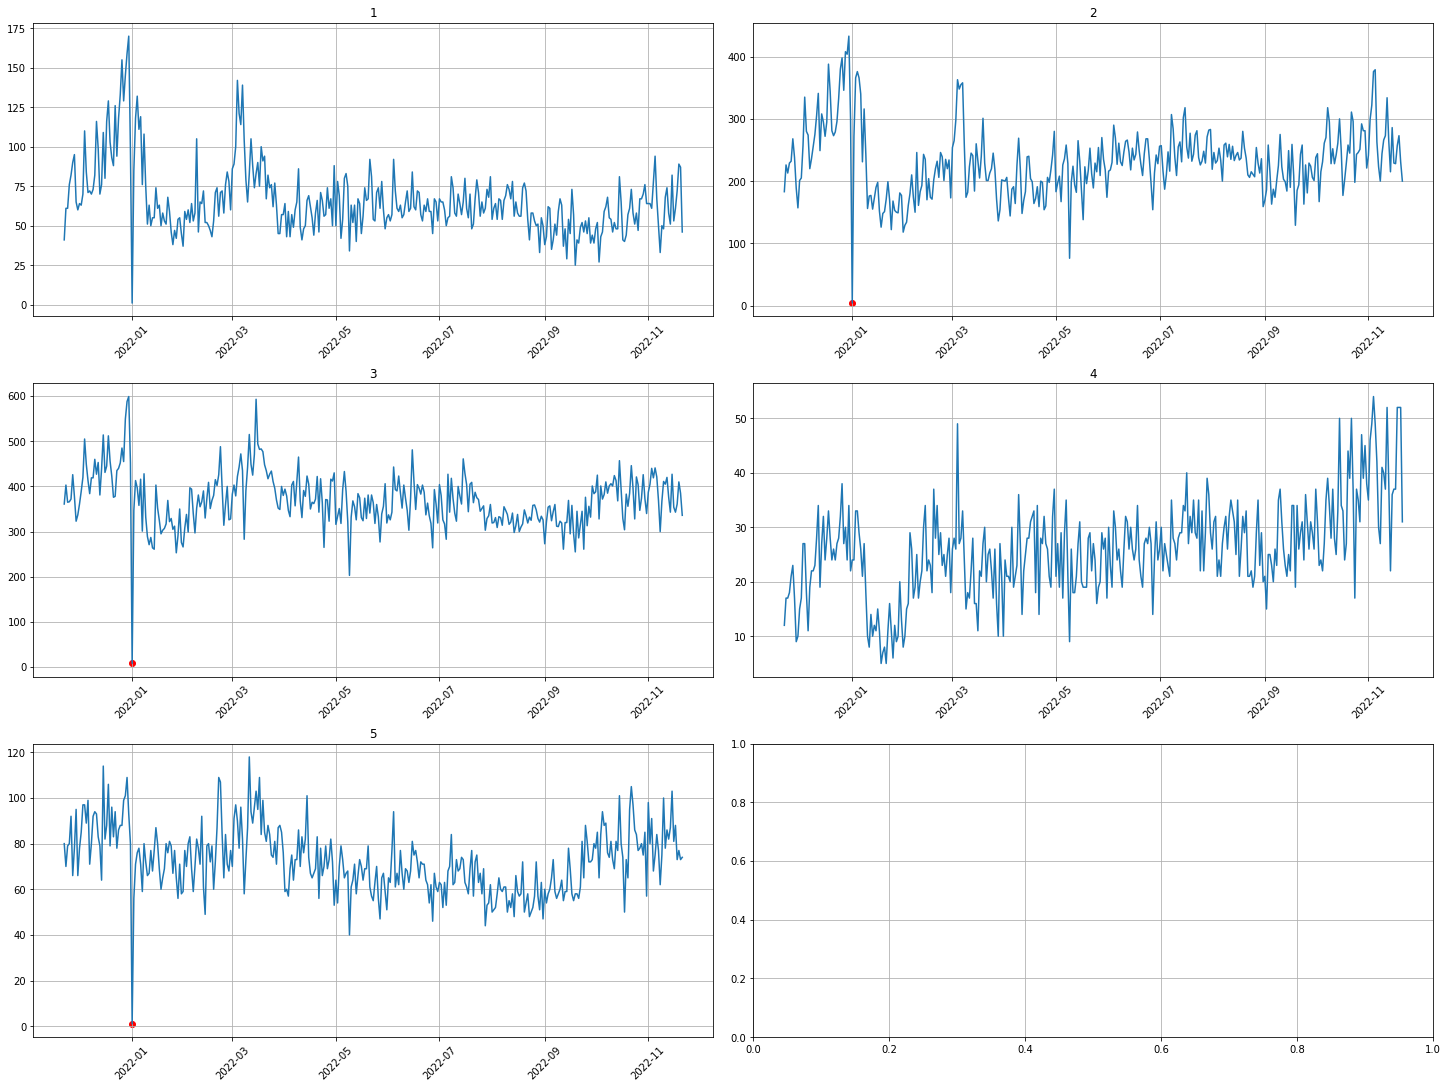

In [242]:
anomaly_dict = get_anomalies_density(ts)
plot_anomalies(ts, anomaly_dict)

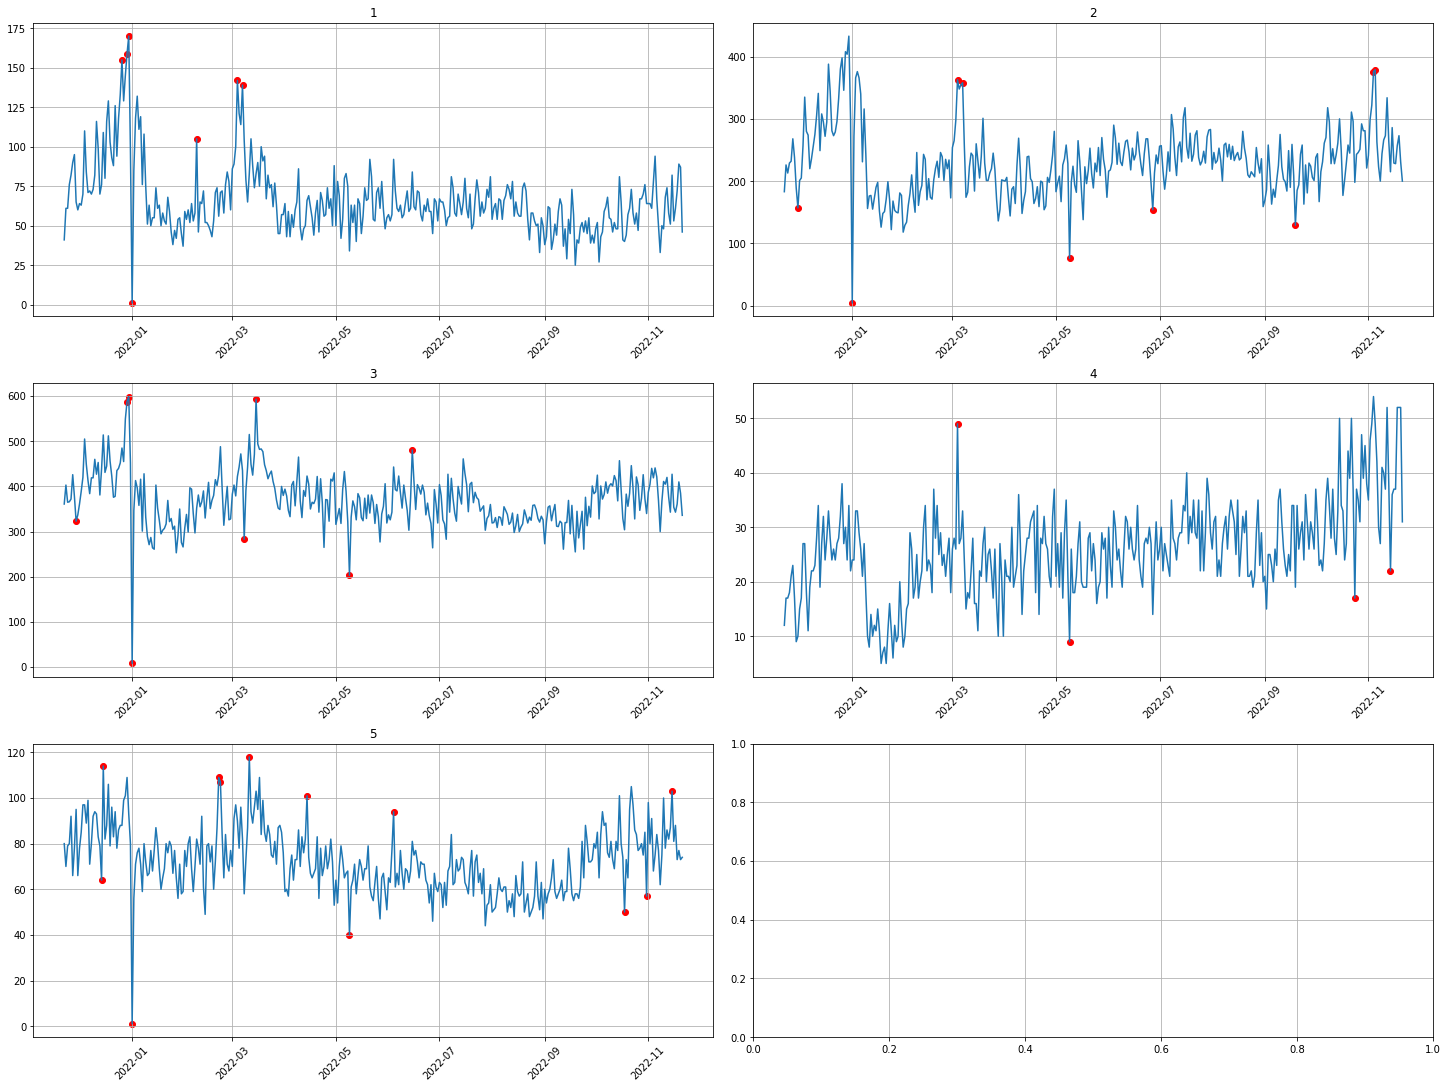

In [243]:
anomaly_dict = get_anomalies_density(ts, window_size=18, distance_coef=1, n_neighbors=4)
plot_anomalies(ts, anomaly_dict)

 Change Points

In [245]:
from etna.analysis import plot_time_series_with_change_points, plot_change_points_interactive
from etna.analysis import find_change_points
from ruptures.detection import Binseg

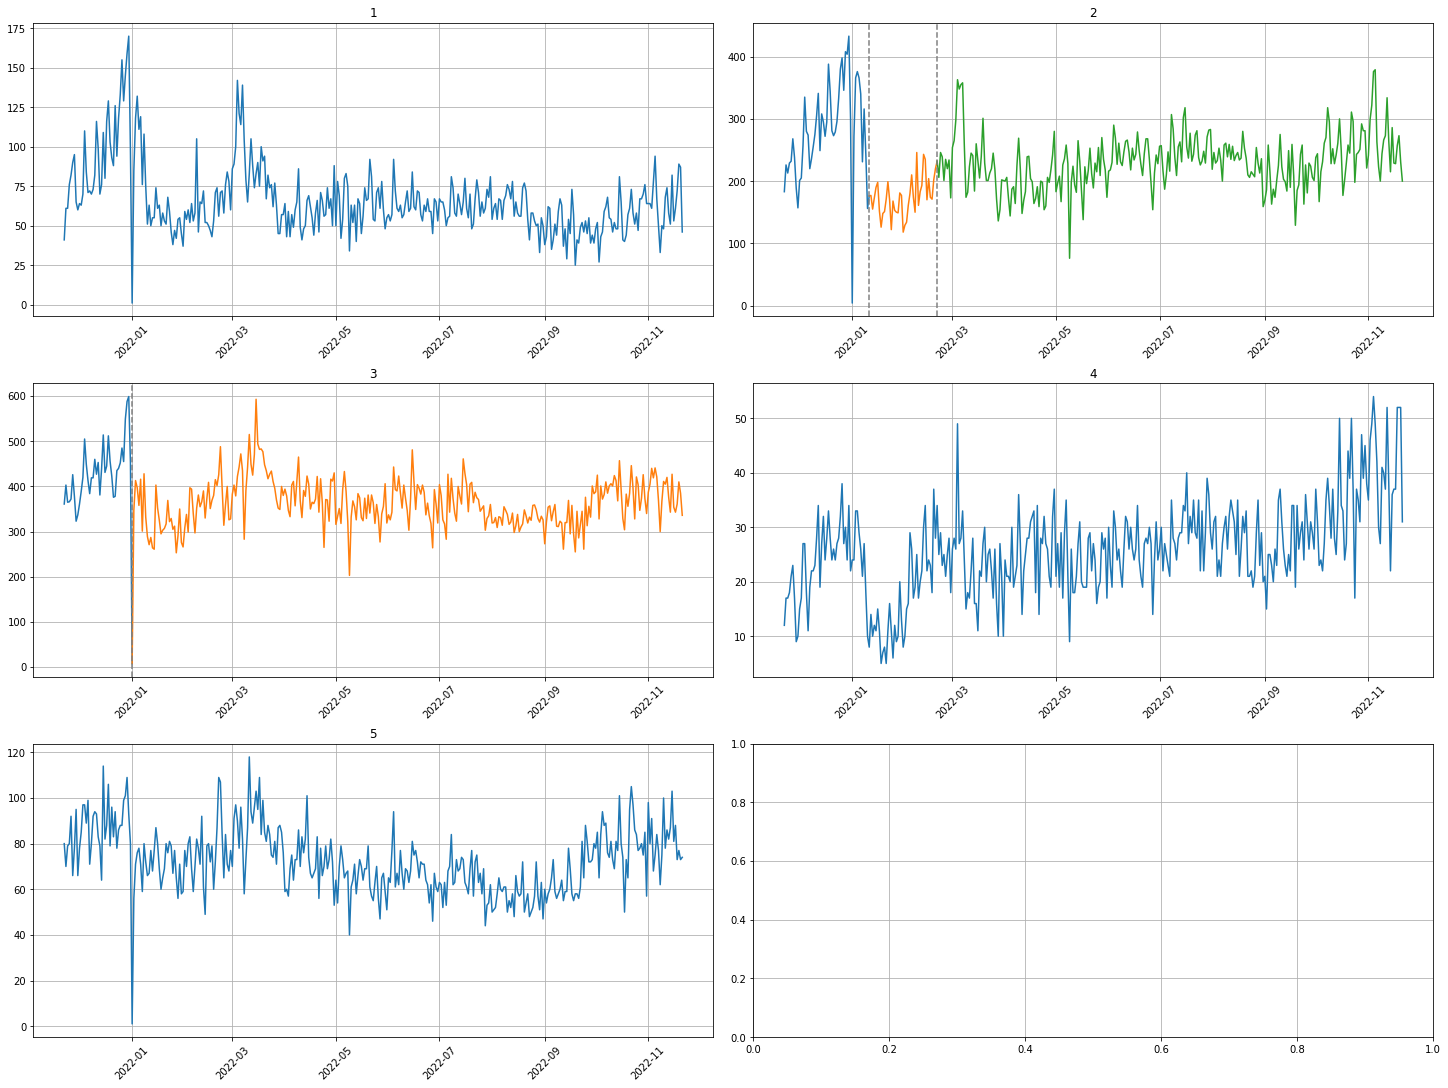

In [246]:
change_points = find_change_points(ts=ts, in_column="target", change_point_model=Binseg(), pen=1e5)
plot_time_series_with_change_points(ts=ts, change_points=change_points)

# ARIMA

data

In [228]:
df_for_etna[df_for_etna.segment == 1]
df_1 = TSDataset.to_dataset(df_for_etna)
ts_1 = TSDataset(df_1, freq="D")

train_ts_1, test_ts_1 = ts_1.train_test_split(
    train_start="2021-11-22",
    train_end="2022-08-31",
    test_start="2022-09-01",
    test_end="2022-11-21",
)

In [230]:
from etna.models import autoarima
model = autoarima.AutoARIMAModel()

In [231]:
model.fit(train_ts_1)
forecast_ts = model.forecast(test_ts_1)

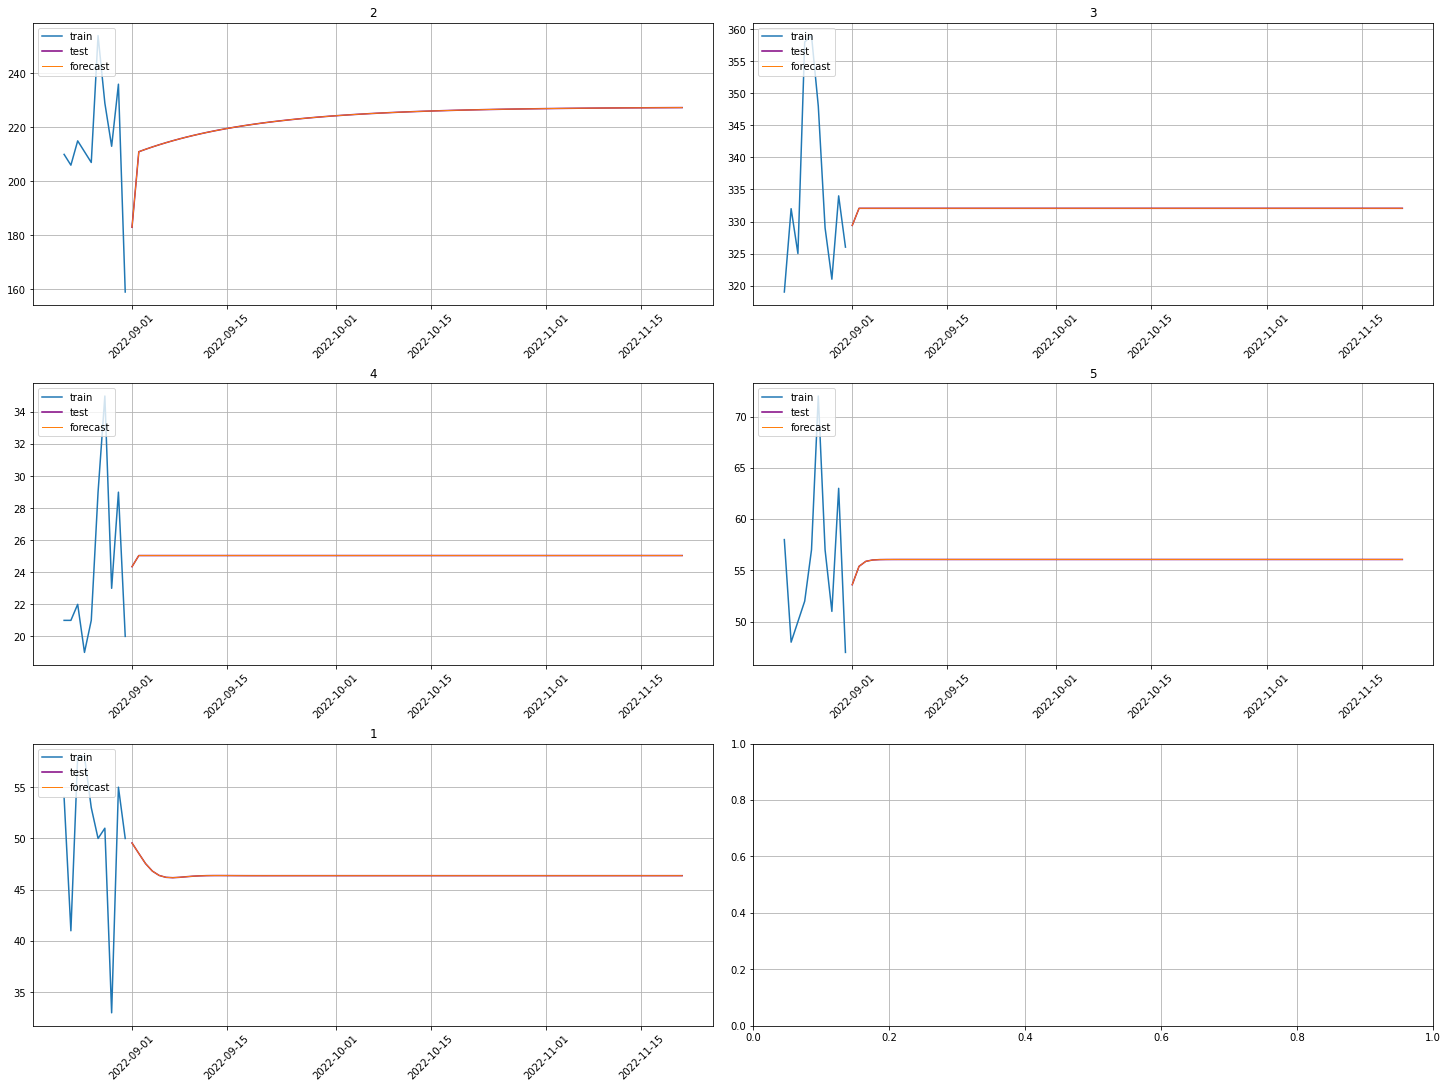

In [232]:
plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=10)

Deep learning examples

In [2]:
import torch
import random

import pandas as pd
import numpy as np

from etna.datasets.tsdataset import TSDataset
from etna.pipeline import Pipeline
from etna.transforms import DateFlagsTransform
from etna.transforms import LagTransform
from etna.transforms import LinearTrendTransform
from etna.metrics import SMAPE, MAPE, MAE
from etna.analysis import plot_backtest
from etna.models import SeasonalMovingAverageModel

import warnings


def set_seed(seed: int = 42):
    """Set random seed for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


warnings.filterwarnings("ignore")

In [12]:
from etna.models.nn.utils import 

ImportError: cannot import name 'PytorchForecastingDatasetBuilder' from 'etna.models.nn.utils' (C:\Users\Dima\AppData\Local\Programs\Python\Python39\lib\site-packages\etna\models\nn\utils.py)

In [7]:
from etna.models.nn import DeepARModel

In [8]:
from pytorch_forecasting.data import GroupNormalizer